我想医生们也还是需要大量进行"传统"的统计学分析的. 这几天正好看到了一个关于贝叶斯分析的PyMC包, 用来做概率计算. 下面的文章里讲解了临床最常见的一些统计应用, 比如参数估计, 组间比较. 看着写起来也不困难, 供参考. 

----

本文翻译自[Eric Ma](https://github.com/ericmjl)在PyCon2017上的演讲Bayesian Statistical Analysis with Python

讲解了使用PyMC3进行基本的贝叶斯统计分析过程. 是很好的PyMC3和贝叶斯统计分析的入门教程. 

* [演讲Slides原文](https://github.com/ericmjl/bayesian-stats-talk) 
* [演讲视频(youtube)](https://www.youtube.com/watch?time_continue=3&v=p1IB4zWq9C8)

In [1]:
# Imports
import pymc3 as pm # python的概率编程包
import numpy.random as npr # numpy是用来做科学计算的
import numpy as np
import matplotlib.pyplot as plt # matplotlib是用来画图的
import matplotlib as mpl

from collections import Counter # ? 
import seaborn as sns # ? 
# import missingno as msno # 用来应对缺失的数据

# Set plotting style
# plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context('poster')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

# 使用python进行贝叶斯统计分析

Eric J. Ma, MIT Biological Engineering, Insight Health Data Science Fellow, NIBR Data Science

PyCon 2017, Portland, OR; PyData Boston 2017, Boston, MA

- HTML Notebook on GitHub: [**ericmjl**.github.io/**bayesian-stats-talk**](https://ericmjl.github.io/bayesian-stats-talk)
- Twitter: [@ericmjl](https://twitter.com/ericmjl)

## 本讲座优点

- **最少的专业术语：**让我们专注于分析原理，而不是术语。 *例如。 将不会解释A / B测试，spike & slab回归，共轭分布... *

- **帕雷托原则：**你需要的80％都是基本知识

 - **享受讲座：**专注于贝叶斯，以后再看代码！

## 假设已经掌握的知识

- 熟悉Python:
    - 对象 & 方法
    - context manager syntax

- 了解基本的统计学术语: 
    - mean: 均值
    - variance: 方差
    - interval: 置信区间

![](https://raw.githubusercontent.com/ericmjl/bayesian-stats-talk/master/images/beliefs.jpg)

## 贝叶斯公式

$$ P(H|D) = \frac{P(D|H)P(H)}{P(D)} $$

- $ P（H|D）$：在给定数据的情况下, 假设为真的概率。(Probability that the hypothesis is true given the data.)
- $ P（D|H）$：假设为真时, 数据事件发生的概率。(Probability of the data arising given the hypothesis.)
- $ P（H）$：假设发生的概率。(Probability that the hypothesis is true, globally.)
- $ P（D）$：数据事件发生的概率。(Probability of the data arising, globally.)


![](https://qph.ec.quoracdn.net/main-qimg-4f187b486bb35176d82ad942dcb20fee-c)

## 贝叶斯主义者的思维方式

> 根据证据不断更新信念

## `pymc3`

![](https://github.com/pymc-devs/pymc3/blob/master/docs/pymc3_logo.jpg?raw=true)

- 用于指定统计模型的**统计分布**，**抽样算法**和**语法**的库
- 一切都用Python！

# 常见的统计分析问题

- **参数估计**: "真实值是否等于X"



- **比较两组实验数据**: "实验组是否与对照组不同? "

# 问题1: 参数估计

"真实值是否等于X?"

或者说

"给定数据，对于感兴趣的参数，可能值的概率分布是多少？"

# 例 1: 抛硬币问题

我把我的硬币抛了$ n $次，正面是$ h $次。 这枚硬币是有偏心的吗？

## 参数估计问题parameterized problem

“我想知道的是抛出正面的概率$ p $，假设$ n $次抛硬币中有$ h $次观察到是正面，$ p $的值是否足够接近$ 0.5 $，比如在$ [0.48，0.52] $？“

## 先验假设

- 对参数预先的假设分布: $ p \sim Uniform(0, 1) $
- likelihood function(似然函数, 翻译这词还不如英文原文呢): $ data \sim Bernoulli(p) $

![](./images/coin_model.jpg)

In [2]:
# 产生所需要的数据
from random import shuffle
total = 30
n_heads = 11
n_tails = total - n_heads
tosses = [1] * n_heads + [0] * n_tails
shuffle(tosses)

## 数据

In [3]:
print(tosses)

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]


In [4]:
def plot_coins():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(list(Counter(tosses).keys()), list(Counter(tosses).values()))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['tails', 'heads'])
    ax.set_ylim(0, 20)
    ax.set_yticks(np.arange(0, 21, 5))
    return fig

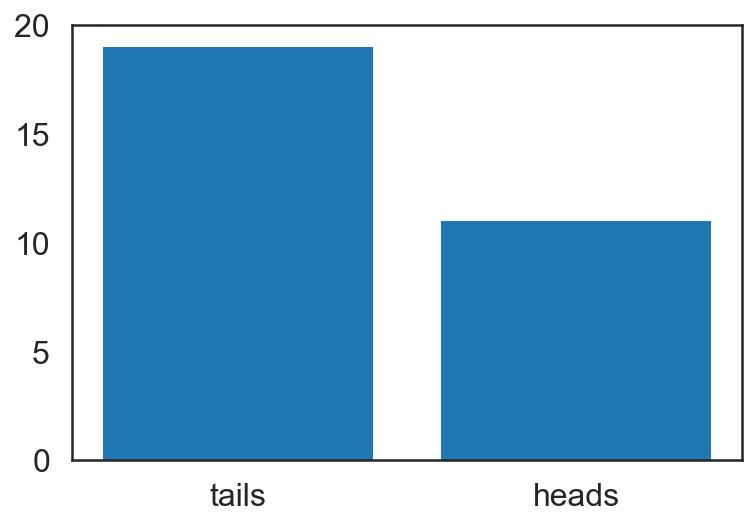

In [5]:
fig = plot_coins()
plt.show()    

## 代码

In [6]:
# Context manager syntax. `coin_model` is **just** 
# a placeholder
with pm.Model() as coin_model: 
    # Distributions are PyMC3 objects.
    # Specify prior using Uniform object.
    p_prior = pm.Uniform('p', 0, 1)  
    
    # Specify likelihood using Bernoulli object.
    like = pm.Bernoulli('likelihood', p=p_prior, 
                        observed=tosses)  
                        # "observed=data" is key
                        # for likelihood.

## MCMC Inference Button (TM)

In [7]:
with coin_model:
    # don't worry about this:
    step = pm.Metropolis()
    
    # focus on this, the Inference Button:
    coin_trace = pm.sample(2000, step=step)

100%|██████████| 2500/2500 [00:03<00:00, 832.65it/s]


## 结果

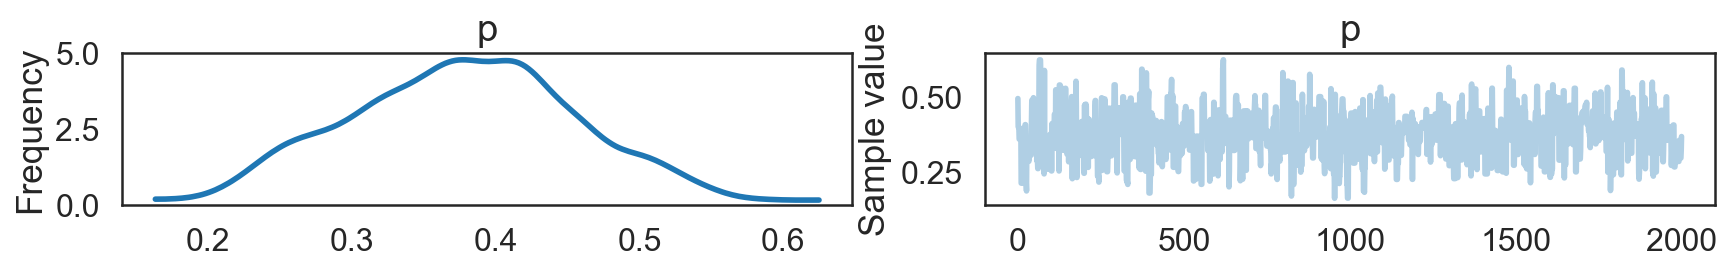

In [8]:
pm.traceplot(coin_trace)
plt.show()

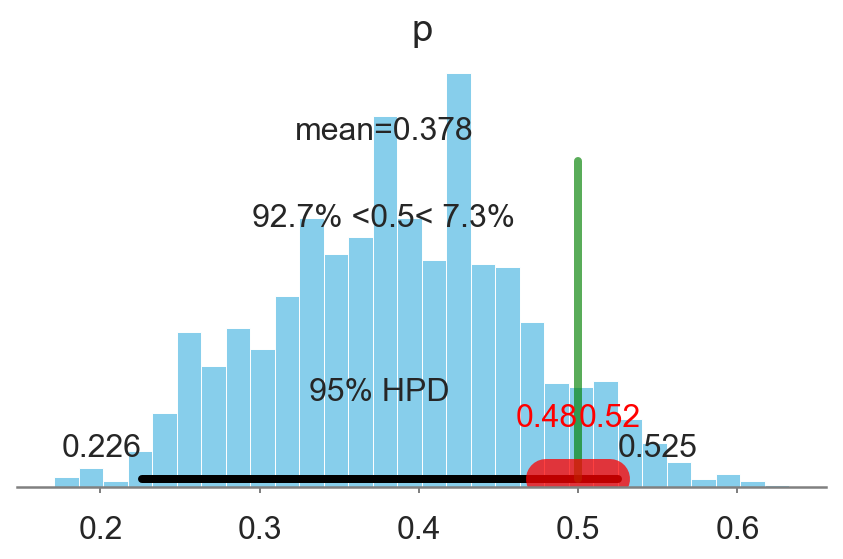

In [9]:
pm.plot_posterior(coin_trace[100:], color='#87ceeb', 
                  rope=[0.48, 0.52], point_estimate='mean', 
                  ref_val=0.5)
plt.show()

- <font style="color:black; font-weight:bold">95% highest posterior density (HPD, 大概类似于置信区间)</font> 包含了 <font style="color:red; font-weight:bold">region of practical equivalence (ROPE, 实际等同区间)</font>. 
- 需要更多的数据!

# 模式

1. 使用统计分布参数化您的问题
1. 修正你的模型结构
1. 在PyMC3中编写模型，点击**Inference 按钮<sup>TM</sup>**
1. 根据后验分布进行解释
1. （可选）如果有新信息，修改模型结构。

# 例 2: 药品活性问题

我有一个新开发的分子X; X在阻止流感病毒复制方面有多好？
<!-- mention verbally about the context: flu, replicating, need molecule to stop it -->

## 实验

- 测试X的浓度范围, 测量流感活性

- 计算 **IC<sub>50</sub>**: 能够抑制病毒复制活性50%的X浓度. 

## data

![](./images/ic50_data.jpg)

In [10]:
import numpy as np
chem_data = [(0.00080, 99),
(0.00800, 91),
(0.08000, 89),
(0.40000, 89),
(0.80000, 79),
(1.60000, 61),
(4.00000, 39),
(8.00000, 25),
(80.00000, 4)]

import pandas as pd

chem_df = pd.DataFrame(chem_data)
chem_df.columns = ['concentration', 'activity']
chem_df['concentration_log'] = chem_df['concentration'].apply(lambda x:np.log10(x))
# df.set_index('concentration', inplace=True)

## 参数化问题parameterized problem

给定数据, 求出化学物质的**IC<sub>50</sub>**值是多少, 并且求出置信区间( 原文中the uncertainty surrounding it, 后面看类似置信区间的含义)?

## 先验知识

- 由药学知识已知测量函数(measurement function): $ m = \frac{\beta}{1 + e^{x - IC_{50}}} $
- 测量函数中的参数估计, 来自先验知识: $ \beta \sim HalfNormal(100^2) $
- 关于感兴趣参数的先验知识: $ log(IC_{50}) \sim ImproperFlat $
- likelihood function: $ data \sim N(m, 1) $

![](./images/ic50_model.jpg)

## 数据

In [11]:
def plot_chemical_data(log=True):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    if log:
        ax.scatter(x=chem_df['concentration_log'], y=chem_df['activity'])
        ax.set_xlabel('log10(concentration (mM))', fontsize=20)
    else:
        ax.scatter(x=chem_df['concentration'], y=chem_df['activity'])
        ax.set_xlabel('concentration (mM)', fontsize=20)
    ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=18)
    ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=18)
    
    plt.hlines(y=50, xmin=min(ax.get_xlim()), xmax=max(ax.get_xlim()), linestyles='--',)
    return fig

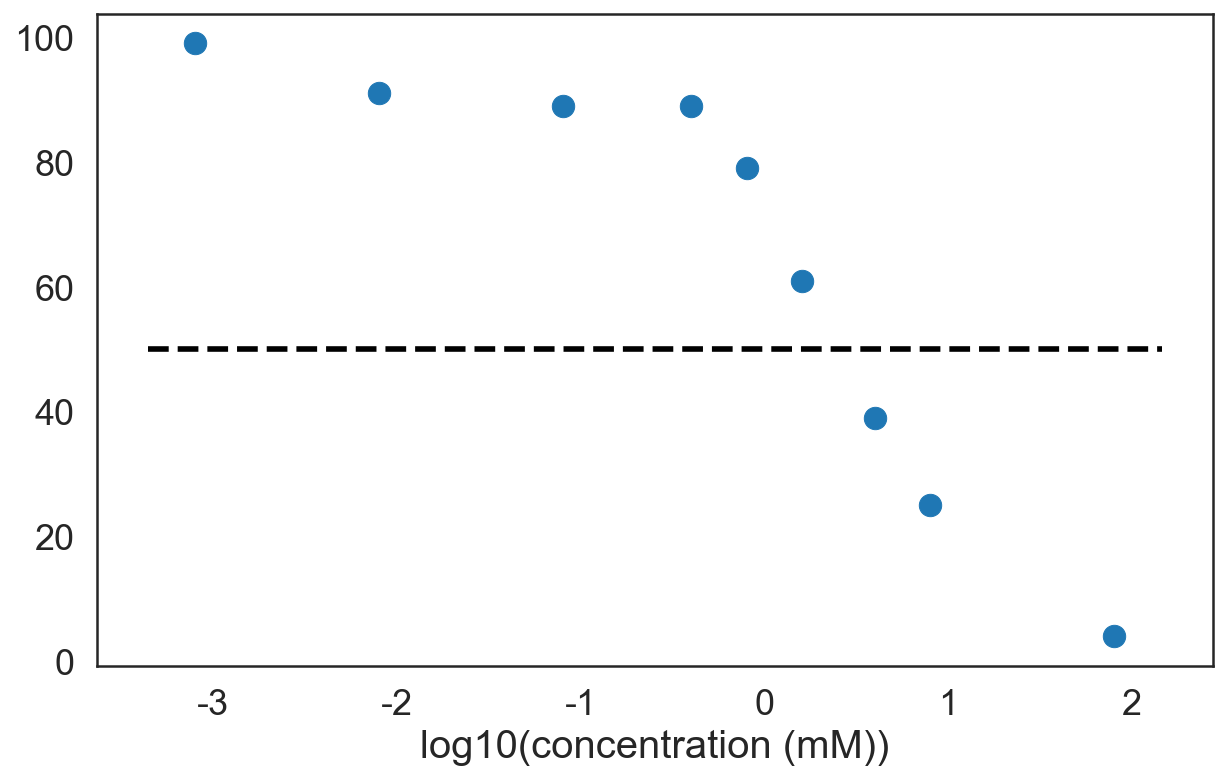

In [12]:
fig = plot_chemical_data(log=True)
plt.show()

## 代码

In [13]:
with pm.Model() as ic50_model: # 都是以这句开头, with pm.Models() as 自己取个名字: 
    beta = pm.HalfNormal('beta', sd=100**2) # 每个参数需要规定分布, 用pm.xxx定义了分布函数
    ic50_log10 = pm.Flat('IC50_log10')  # Flat prior
    # MATH WITH DISTRIBUTION OBJECTS! # 测量函数的计算过程, 这个也是来自于先验知识
    measurements = beta / (1 + np.exp(chem_df['concentration_log'].values - 
                                      ic50_log10))
    
    y_like = pm.Normal('y_like', mu=measurements, 
                       observed=chem_df['activity']) # 这是啥? 
    # Deterministic transformations.
    ic50 = pm.Deterministic('IC50', np.power(10, ic50_log10)) # ic50_log10是在对数域, 要转换回来

## MCMC Inference Button (TM)

In [14]:
with ic50_model: # 在之前定义的模型中模拟
    step = pm.Metropolis() # 标准步骤, 照写
    ic50_trace = pm.sample(100000, step=step) # 随机模拟过程, 重采样的次数手工指定

100%|██████████| 100500/100500 [00:41<00:00, 2411.75it/s]


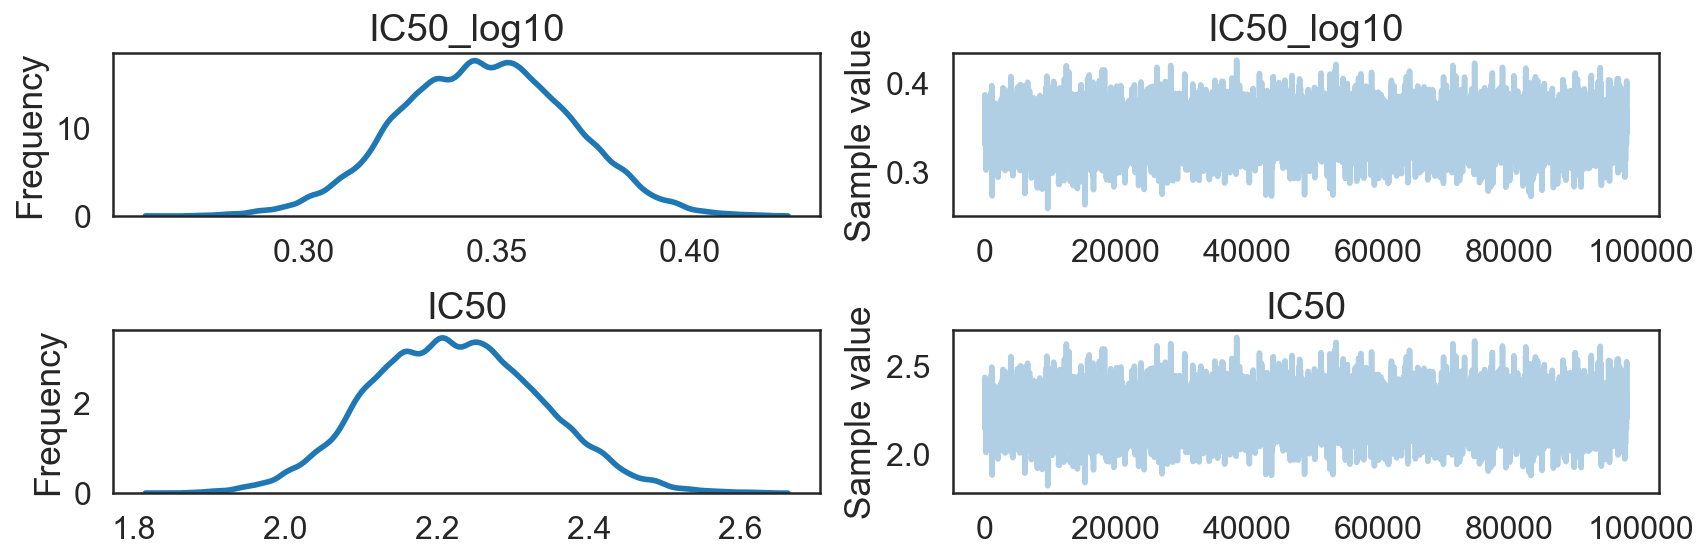

In [15]:
pm.traceplot(ic50_trace[2000:], varnames=['IC50_log10', 'IC50'])  # live: sample from step 2000 onwards.
plt.show()

## 结果

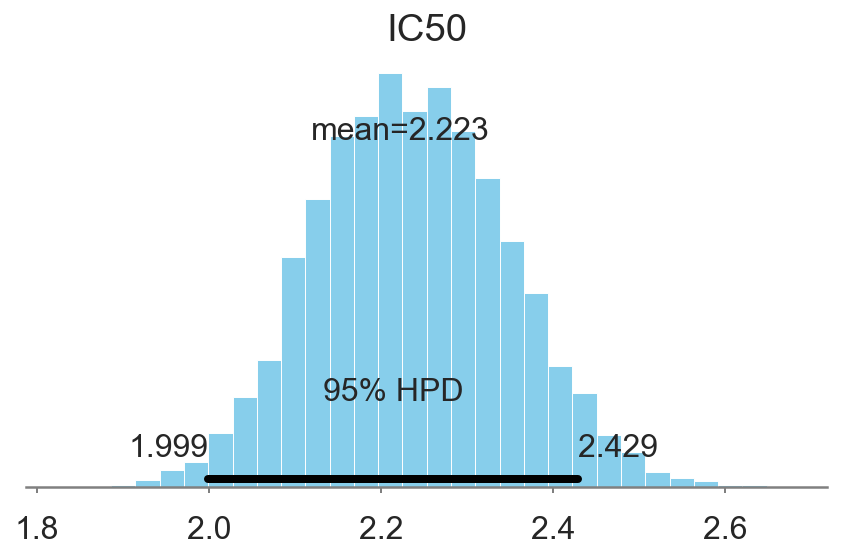

In [16]:
pm.plot_posterior(ic50_trace[4000:], varnames=['IC50'], 
                  color='#87ceeb', point_estimate='mean')
plt.show()

该化学物质的 IC<sub>50</sub> 大约在[2 mM, 2.4 mM] (95% HPD). 这不是个好的药物候选者. 在这个问提上不确定性影响不大, 看看单位数量级就知道IC<sub>50</sub>在毫摩的物质没什么用... 

# 第二类问题: 实验组之间的比较

"实验组和对照组之间是否有差别? "

# 例 1: 药品对IQ的影响问题

药品治疗是否影响(提高)IQ分数? 

(documented in Kruschke, 2013, example modified from PyMC3 documentation)

In [17]:
drug = [  99.,  110.,  107.,  104.,  103.,  105.,  105.,  110.,   99.,
        109.,  100.,  102.,  104.,  104.,  100.,  104.,  101.,  104.,
        101.,  100.,  109.,  104.,  105.,  112.,   97.,  106.,  103.,
        101.,  101.,  104.,   96.,  102.,  101.,  100.,   92.,  108.,
         97.,  106.,   96.,   90.,  109.,  108.,  105.,  104.,  110.,
         92.,  100.]

placebo = [  95.,  105.,  103.,   99.,  104.,   98.,  103.,  104.,  102.,
         91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
         97.,   94.,  104.,   92.,   98.,  105.,  106.,  101.,  106.,
        105.,  101.,  105.,  102.,   95.,   91.,   99.,   96.,  102.,
         94.,   93.,   99.,   99.,  113.,   96.]

def ECDF(data):
    x = np.sort(data)
    y = np.cumsum(x) / np.sum(x)
    
    return x, y

def plot_drug():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    x_drug, y_drug = ECDF(drug)
    ax.plot(x_drug, y_drug, label='drug, n={0}'.format(len(drug)))
    x_placebo, y_placebo = ECDF(placebo)
    ax.plot(x_placebo, y_placebo, label='placebo, n={0}'.format(len(placebo)))
    ax.legend()
    ax.set_xlabel('IQ Score')
    ax.set_ylabel('Cumulative Frequency')
    ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--')
    
    return fig

In [18]:
# Eric Ma自己很好奇, 从频率主义的观点, 差别是否已经是具有"具有统计学意义"

from scipy.stats import ttest_ind

ttest_ind(drug, placebo) # (非配对) t检验. P=0.025, 已经<0.05了

Ttest_indResult(statistic=2.2806701634329549, pvalue=0.025011500508647616)

## 实验

- 参与者被随机分为两组: 
    - `给药组` vs. `安慰剂组`
- 测量参与者的IQ分数

## 先验知识
- 被测数据符合t分布: $ data \sim StudentsT(\mu, \sigma, \nu) $

以下为t分布的几个参数: 
- 均值符合正态分布: $ \mu \sim N(0, 100^2) $
- 自由度(degrees of freedom)符合指数分布: $ \nu \sim Exp(30) $
- 方差是positively-distributed: $ \sigma \sim HalfCauchy(100^2) $

![](./images/kruschke_model.jpg)

## 数据

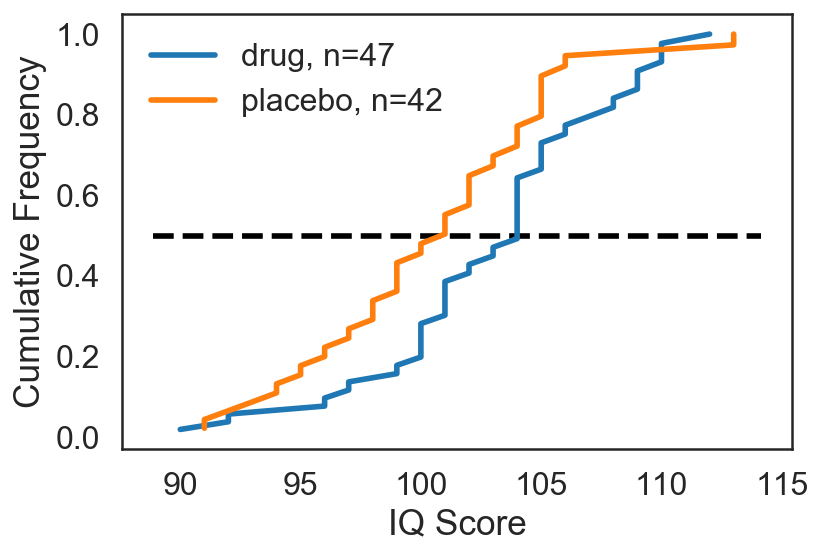

In [19]:
fig = plot_drug()
plt.show()

## 代码

In [20]:
y_vals = np.concatenate([drug, placebo])
labels = ['drug'] * len(drug) + ['placebo'] * len(placebo)

data = pd.DataFrame([y_vals, labels]).T
data.columns = ['IQ', 'treatment']

In [21]:
with pm.Model() as kruschke_model:
    # Focus on the use of Distribution Objects.
    # Linking Distribution Objects together is done by 
    # passing objects into other objects' parameters.
    
    # 标准建模动作, 用pm.Xxx指定先验知识, 也就是各个参数的分布
    # 注意给药组和对照组的参数要分开单独设定, 
    mu_drug = pm.Normal('mu_drug', mu=0, sd=100**2)
    mu_placebo = pm.Normal('mu_placebo', mu=0, sd=100**2)
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100) 
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    # 代入参数, 为两组的分布建模
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=drug)
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=placebo)
    
    # 计算组间均值的差距
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    
    # 这俩是啥? 
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sigma_drug, 2) + 
                                         np.power(sigma_placebo, 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

## MCMC Inference Button (TM)

In [22]:
with kruschke_model:
    kruschke_trace = pm.sample(10000, step=pm.Metropolis()) # 标准动作, 照写

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
100%|██████████| 10500/10500 [00:16<00:00, 622.64it/s]


## 结果

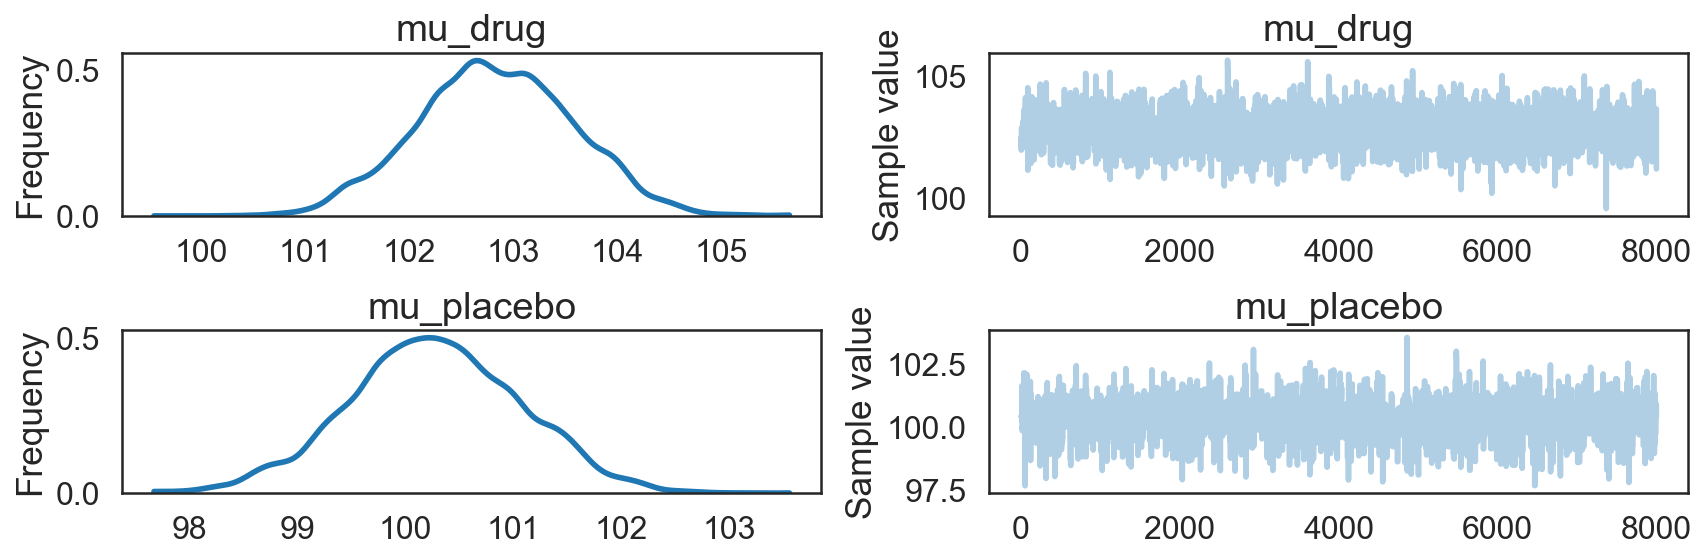

In [23]:
pm.traceplot(kruschke_trace[2000:], 
             varnames=['mu_drug', 'mu_placebo'])
plt.show()

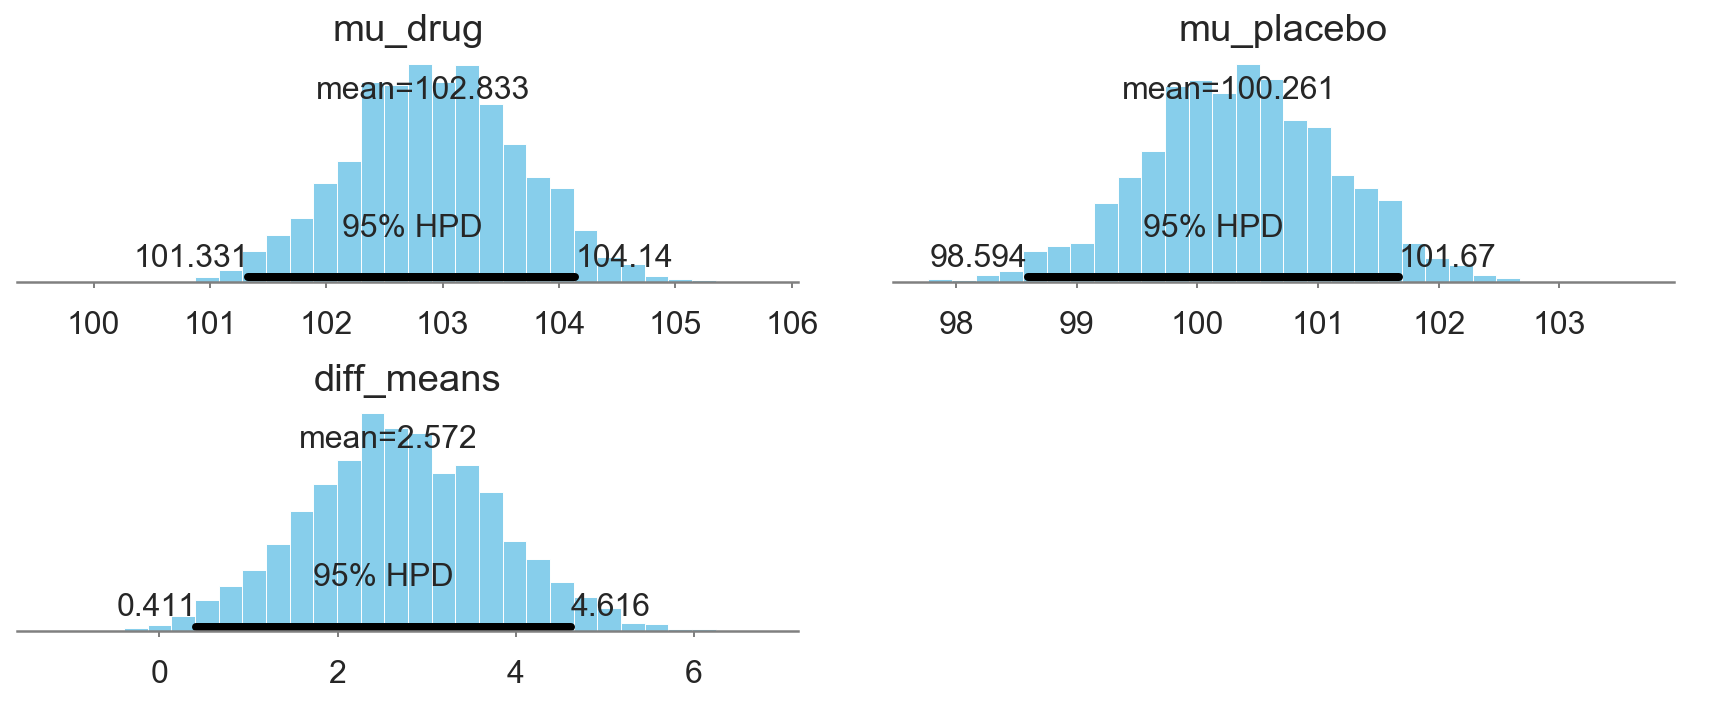

In [24]:
pm.plot_posterior(kruschke_trace[2000:], color='#87ceeb',
            varnames=['mu_drug', 'mu_placebo', 'diff_means'])
plt.show()

- IQ均值的差距为: [0.5, 4.6]
- 频率主义的 p-value: $ 0.02 $ (!!!!!!!!)

注: IQ的差异在10以上才有点意义. p-value=0.02说明组间有差异, 但没说差异有多大. 这个故事说的是虽然有差异, 但是差异太小了, 也没啥意思. 

In [25]:
def get_forestplot_line(ax, kind):
    widths = {'median': 2.8, 'iqr': 2.0, 'hpd': 1.0}
    assert kind in widths.keys() #f'line kind must be one of {widths.keys()}'
    lines = []
    for child in ax.get_children():
        if isinstance(child, mpl.lines.Line2D) and np.allclose(child.get_lw(), widths[kind]):
            lines.append(child)
    return lines

def adjust_forestplot_for_slides(ax):    
    for line in get_forestplot_line(ax, kind='median'):
        line.set_markersize(10)

    for line in get_forestplot_line(ax, kind='iqr'):
        line.set_linewidth(5)

    for line in get_forestplot_line(ax, kind='hpd'):
        line.set_linewidth(3)
        
    return ax

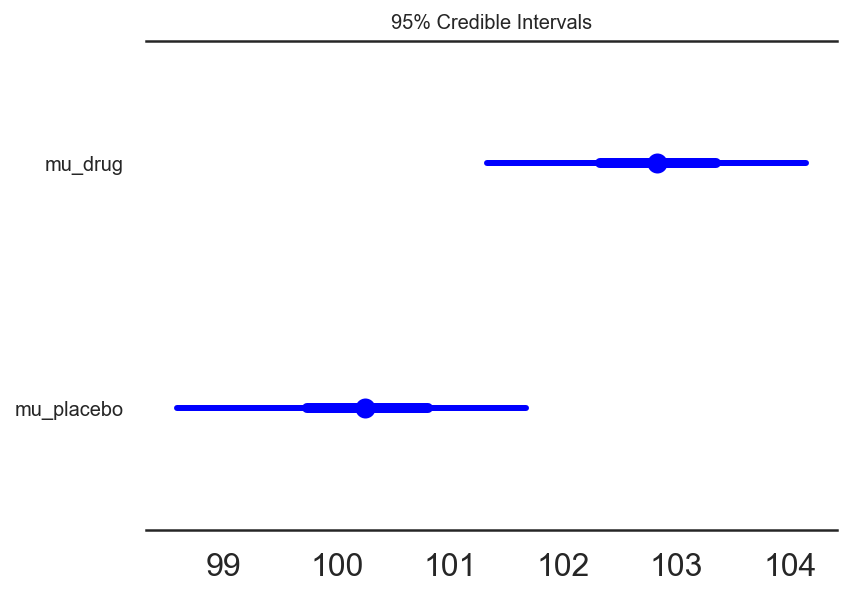

In [26]:
pm.forestplot(kruschke_trace[2000:], 
          varnames=['mu_drug', 'mu_placebo'])
ax = plt.gca()
ax = adjust_forestplot_for_slides(ax)
plt.show()

**森林图**：在同一轴上的95％HPD（细线），IQR（粗线）和后验分布的中位数（点），使我们能够直接比较治疗组和对照组。


In [27]:
def overlay_effect_size(ax):
    height = ax.get_ylim()[1] * 0.5
    ax.hlines(height, 0, 0.2, 'red', lw=5)
    ax.hlines(height, 0.2, 0.8, 'blue', lw=5)
    ax.hlines(height, 0.8, ax.get_xlim()[1], 'green', lw=5)

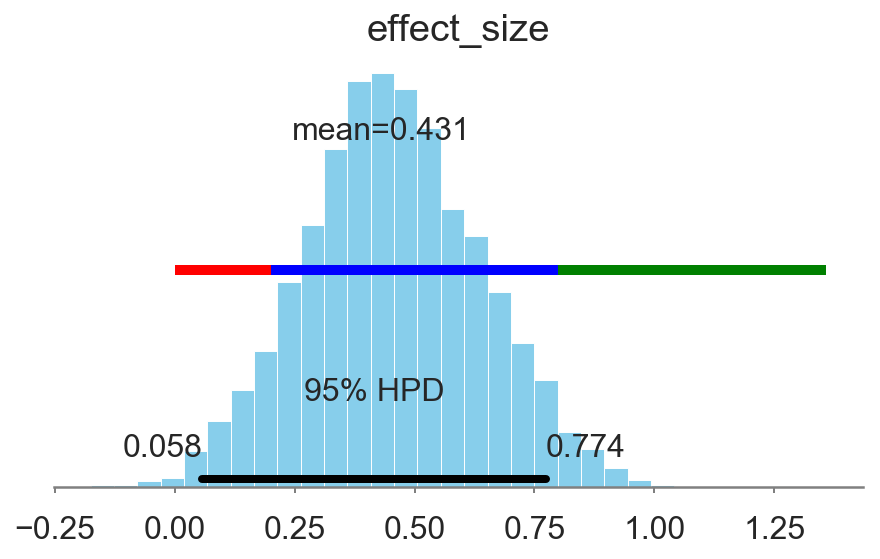

In [28]:
ax = pm.plot_posterior(kruschke_trace[2000:], 
                       varnames=['effect_size'],
                       color='#87ceeb')
overlay_effect_size(ax)

- 效果大小（Cohen's d, <font style="color:red;">效果微小</font>, <font style="color:blue;">效果中等</font>, <font style="color:green;">效果很大</font>）可以从微小到很大（95％HPD [0.0，0.77]）。
- 智商提高0-4分。
- 这种药很可能是无关紧要的。
- 没有**生物学意义**的证据。

# 例 2: 手机消毒问题

比较两种常用的消毒方法, 和我的fancy方法, 哪种消毒方法更好

## 实验设计

- 将手机随机分到6组: 4 "fancy" 方法 + 2 "control" 方法.
- 处理前后对手机表面进行拭子菌培养
- **count** 菌落数量, 比较处理前后的菌落计数

In [29]:
renamed_treatments = dict()
renamed_treatments['FBM_2'] = 'FM1'
renamed_treatments['bleachwipe'] = 'CTRL1'
renamed_treatments['ethanol'] = 'CTRL2'
renamed_treatments['kimwipe'] = 'FM2'
renamed_treatments['phonesoap'] = 'FM3'
renamed_treatments['quatricide'] = 'FM4'

# Reload the data one more time.
data = pd.read_csv('datasets/smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])
del data['perc_reduction colonies']

# Exclude cellblaster data
data = data[data['treatment'] != 'CB30']
data = data[data['treatment'] != 'cellblaster']

# Rename treatments
data['treatment'] = data['treatment'].apply(lambda x: renamed_treatments[x])

# Sort the data according to the treatments.
treatment_order = ['FM1', 'FM2', 'FM3', 'FM4', 'CTRL1', 'CTRL2']
data['treatment'] = data['treatment'].astype('category')
data['treatment'].cat.set_categories(treatment_order, inplace=True)
data['treatment'] = data['treatment'].cat.codes.astype('int32')
data = data.sort_values(['treatment']).reset_index(drop=True)
data['site'] = data['site'].astype('category').cat.codes.astype('int32')

data['frac_change_colonies'] = ((data['colonies_post'] - data['colonies_pre']) 
                                / data['colonies_pre'])
data['frac_change_colonies'] = pm.floatX(data['frac_change_colonies'])
del data['screen protector']

# Change dtypes to int32 for GPU usage.
def change_dtype(data, dtype='int32'):
    return data.astype(dtype)

cols_to_change_ints = ['sample_id', 'colonies_pre', 'colonies_post',
                       'morphologies_pre', 'morphologies_post', 'phone ID']

cols_to_change_floats = ['year', 'month', 'day', 'perc_reduction morph',
                         'phone ID', 'no case',]

for col in cols_to_change_ints:
    data[col] = change_dtype(data[col], dtype='int32')
    
for col in cols_to_change_floats:
    data[col] = change_dtype(data[col], dtype='float32')

data.dtypes


# # filter the data such that we have only PhoneSoap (PS-300) and Ethanol (ET)
# data_filtered = data[(data['treatment'] == 'PS-300') | (data['treatment'] == 'QA')]
# data_filtered = data_filtered[data_filtered['site'] == 'phone']
# data_filtered.sample(10)

FileNotFoundError: File b'datasets/smartphone_sanitization_manuscript.csv' does not exist

## 数据

In [ ]:
def plot_colonies_data():
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(2,1,1)
    sns.swarmplot(x='treatment', y='colonies_pre', data=data, ax=ax1)
    ax1.set_title('pre-treatment')
    ax1.set_xlabel('')
    ax1.set_ylabel('colonies')
    ax2 = fig.add_subplot(2,1,2)
    sns.swarmplot(x='treatment', y='colonies_post', data=data, ax=ax2)
    ax2.set_title('post-treatment')
    ax2.set_ylabel('colonies')
    ax2.set_ylim(ax1.get_ylim())
    plt.tight_layout()
    return fig

In [ ]:
fig = plot_colonies_data()
plt.show()

## 先验知识

菌落计数符合**泊松Poisson分布**. 因此...

- 菌落计数符合泊松分布: $ data_{i}^{j} \sim Poisson(\mu_{i}^{j}), j \in [pre, post], i \in [1, 2, 3...] $
- 泊松分布的参数是离散均匀分布: $ \mu_{i}^{j} \sim DiscreteUniform(0, 10^{4}), j \in [pre, post], i \in [1, 2, 3...] $
- 灭菌效力通过百分比变化测量，定义如下: $ \frac{mu_{pre} - mu_{post}}{mu_{pre}} $

![](./images/bacteria_model.jpg)

## 代码

In [ ]:
with pm.Model() as poisson_estimation:
    
    mu_pre = pm.DiscreteUniform('pre_mus', lower=0, upper=10000, 
                                shape=len(treatment_order))
    pre_mus = mu_pre[data['treatment'].values]  # fancy indexing!!
    pre_counts = pm.Poisson('pre_counts', mu=pre_mus, 
                            observed=pm.floatX(data['colonies_pre']))
    
    mu_post = pm.DiscreteUniform('post_mus', lower=0, upper=10000, 
                                 shape=len(treatment_order))
    post_mus = mu_post[data['treatment'].values]  # fancy indexing!!
    post_counts = pm.Poisson('post_counts', mu=post_mus, 
                             observed=pm.floatX(data['colonies_post']))

    perc_change = pm.Deterministic('perc_change', 
                                   100 * (mu_pre - mu_post) / mu_pre)     

## MCMC Inference Button (TM)

In [ ]:
with poisson_estimation:
    poisson_trace = pm.sample(200000)

In [ ]:
pm.traceplot(poisson_trace[50000:], varnames=['pre_mus', 'post_mus'])
plt.show()

## 结果

In [ ]:
pm.forestplot(poisson_trace[50000:], varnames=['perc_change'], 
              ylabels=treatment_order) #, xrange=[0, 110])
plt.xlabel('Percentage Reduction')

ax = plt.gca()
ax = adjust_forestplot_for_slides(ax)

# 第三类问题: 复杂的东西

# 例子: 贝叶斯神经网络

a.k.a. 贝叶斯深度学习

![bayesian neural networks](https://raw.githubusercontent.com/ericmjl/bayesian-stats-talk/master/images/bayesian-neural-net.jpg)

[Forest Cover Notebook](https://github.com/ericmjl/bayesian-analysis-recipes/blob/master/multiclass-classification-neural-network.ipynb)

注: 这好像跳到另一个课件去了. 有时间我也挪过来翻译

# 概念特征

- 参数估计：
     - **抛硬币：** 先验与后验
     - ** IC <sub> 50 </ sub>：**连接函数与确定性计算
- 对照与治疗：
     - **药物智商：**一个治疗组 与 一个对照组
     - **电话消毒：**多个治疗组 与 多个对照组。
- 贝叶斯神经网络：
     - **森林覆盖：**先验参数和大致推断。

# 模式

1. 使用统计分布参数化您的问题
1. 修正你的模型结构
1. 在PyMC3中编写模型，点击**Inference 按钮<sup>TM</sup>**
1. 根据后验分布进行解释
1. （可选）如果有新信息，修改模型结构。

# 贝叶斯估计

- 为数据的生成写一个**描述性的**模型。
     - 原始的贝叶斯：在**看到你的数据之前** 做这个。
     - 经验贝叶斯：在**看到你的数据之后**做这个。
- 估计感兴趣的模型参数的**后验分布**。
- **确定性计算** 派生参数的后验分布。

# 参考资源

- John K. Kruschke's [books][kruschke_books], [paper][kruschke_paper], and [video][kruschke_video].
- Statistical Re-thinking [book][mcelreath]
- Jake Vanderplas' [blog post][jakevdp_blog] on the differences between Frequentism and Bayesianism.
- PyMC3 [examples & documentation][pymc3]
- Andrew Gelman's [blog][gelman]
- Recommendations for prior distributions [wiki][priors] 
- Cam Davidson-Pilon's [Bayesian Methods for Hackers][bayes_hacks]
- My [repository][bayes_recipes] of Bayesian data analysis recipes.

[kruschke_books]: https://sites.google.com/site/doingbayesiandataanalysis/
[kruschke_paper]: http://www.indiana.edu/~kruschke/BEST/
[kruschke_video]: https://www.youtube.com/watch?v=fhw1j1Ru2i0&feature=youtu.be
[jakevdp_blog]: http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/
[pymc3]: https://pymc-devs.github.io/pymc3/examples.html
[mcelreath]: http://xcelab.net/rm/statistical-rethinking/
[gelman]: http://andrewgelman.com/
[priors]: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
[bayes_hacks]: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
[bayes_recipes]: https://github.com/ericmjl/bayesian-analysis-recipes

# GO BAYES!

- Full notebook with bonus resources: https://github.com/ericmjl/bayesian-stats-talk
- Twitter: [@ericmjl](https://twitter.com/ericmjl)
- Website: [ericmjl.com](http://www.ericmjl.com)